In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sklearn.linear_model
from tqdm import tqdm

# Load dataset

In [3]:
X, odors = np.load('datasets/KC/features.npy'), np.load('datasets/KC/labels.npy')

In [4]:
x_dim, samples = X.shape

In [5]:
y = np.zeros((3,samples))

for t in range(samples):
    if odors[t]==1: y[:,t] = [1,1,1]
    elif odors[t]==2: y[:,t] = [0,1,1]
    elif odors[t]==3: y[:,t] = [0,0,1]
    else: y[:,t] = [0,0,0]

In [6]:
epsilon = .01

# Optimal solution

In [7]:
# # calculate class means 

# mu0 = np.zeros((3,x_dim))
# mu1 = np.zeros((3,x_dim))
# cov = np.zeros((3,x_dim,x_dim))

# for i in range(3):

#     samples_1 = np.sum(y)
#     samples_0 = samples - samples_1

#     for t in range(samples):
#         if y[i,t] == 0:
#             mu0[i] += X[:,t]
#         elif y[i,t] == 1:
#             mu1[i] += X[:,t]

#     mu0[i] /= samples_0
#     mu1[i] /= samples_1

#     # calculate sample variance

#     for t in range(samples):
#         if y[i,t] == 0:
#             cov[i] += np.outer(X[:,t]-mu0[i],X[:,t]-mu0[i])
#         elif y[i,t] == 1:
#             cov[i] += np.outer(X[:,t]-mu1[i],X[:,t]-mu1[i])

#     cov[i] /= samples_0

#     # add epsilon*identity to ensure that cov is invertible

#     cov[i] += epsilon*np.eye(x_dim)

In [8]:
# w_opt = np.zeros((3,x_dim))
# w_opt_norm = np.zeros(3)
# bias_opt = np.zeros(3)

# for i in range(3):

#     w_opt[i] = np.linalg.inv(cov[i])@(mu0[i]-mu1[i])
#     w_opt_norm[i] = np.linalg.norm(w_opt[i])
#     bias_opt[i] = .5*np.inner(w_opt[i],mu0[i]+mu1[i])

# Online algorithms

In [9]:
trials = 10; epochs = 10**2; eta0 = 1e-1; decay = 1e-4; iters = epochs*samples

In [10]:
classes = np.unique(y[0])

In [11]:
model = sklearn.linear_model.SGDClassifier(
    fit_intercept=False,
    learning_rate="constant",
    eta0=1E-3,  # this is the learning rate
    )

In [17]:
# X_train, X_test, y_train, y_test = X.T, X.T, y[0], y[0]

# n_iters = 500
# batch_size = 1
# indices = np.arange(samples)
# pbar = tqdm(range(n_iters), mininterval=1)
# accs = []
# losses = []

# for i in pbar:
#   idx = np.random.choice(indices, batch_size)
#   x, class_label = X.T[idx], y[0,idx]
#   model.partial_fit(x, class_label, classes)
#   model.predict(x)

In [13]:
accuracy = np.zeros((3,trials,iters))
accuracy_svm = np.zeros((3,trials,iters))

for p in range(3):

    print(f'p = {(p+1)/7}')

    for trial in range(trials):

        print(f'Trial {trial+1}:')

        w = np.random.randn(x_dim); sample_mu0 = 0; zeta = 0; sample_bias = 0; l = 1

        for epoch in range(epochs):

            idx = np.random.permutation(samples)

            for t in range(samples):

                iter = epoch*samples + t

                x, class_label = X[:,idx[t]], y[p,idx[t]]

                c = np.inner(w,x)

                step = eta0/(1+decay*iter)

                if class_label==0:

                    sample_mu0 += (x-sample_mu0)/1000
                    sample_bias += (c/2-sample_bias)/1000
                    zeta += (c-zeta)/1000

                    w += step*(sample_mu0-(c-zeta)*(x-sample_mu0))
                    l += 1

                elif class_label==1:

                    sample_bias += (l*c/2-np.log(l)-sample_bias)/1000
                    w += step*(sample_mu0-l*x)
                    l = 1

                z = c-sample_bias

                accuracy[p,trial,iter] = np.abs((np.sign(z)+1)/2 - class_label)

                # svm update

                model.partial_fit(x.reshape(1,x_dim), np.array([class_label,]), classes)
                accuracy_svm[p,trial,iter] = 1 - np.abs(model.predict(x.reshape(1,x_dim))-class_label)

p = 0.14285714285714285
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:
p = 0.2857142857142857
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:
p = 0.42857142857142855
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:


In [14]:
mean_accuracy = np.zeros((3,trials,iters))
mean_accuracy_svm = np.zeros((3,trials,iters))

for p in range(3):

    for trial in range(trials):

        for iter in range(iters):

            if iter<100:
                mean_accuracy[p,trial,iter] = np.sum(accuracy[p,trial,0:iter])/max(iter,1)
                mean_accuracy_svm[p,trial,iter] = np.sum(accuracy_svm[p,trial,0:iter])/max(iter,1)
            
            elif iter>=100:
                mean_accuracy[p,trial,iter] = np.sum(accuracy[p,trial,iter-100:iter])/100
                mean_accuracy_svm[p,trial,iter] = np.sum(accuracy_svm[p,trial,iter-100:iter])/100

In [15]:
np.save('KC.npy',mean_accuracy)
np.save('KC_svm.npy',mean_accuracy_svm)

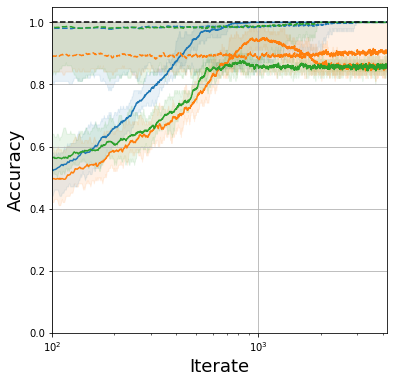

In [16]:
fs = 18

t = np.linspace(1,iters,iters)

fig = plt.figure(figsize=(6,6))

plt.semilogx(t,mean_accuracy[0].mean(axis=0),color='C0')
plt.fill_between(t,np.amin(mean_accuracy[0],axis=0),np.amax(mean_accuracy[0],axis=0),alpha=.1,color='C0')
plt.semilogx(t,mean_accuracy_svm[0].mean(axis=0),color='C0',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[0],axis=0),np.amax(mean_accuracy_svm[0],axis=0),alpha=.1,color='C0')
plt.semilogx(t,mean_accuracy[1].mean(axis=0),color='C1')
plt.fill_between(t,np.amin(mean_accuracy[1],axis=0),np.amax(mean_accuracy[1],axis=0),alpha=.1,color='C1')
plt.semilogx(t,mean_accuracy_svm[1].mean(axis=0),color='C1',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[1],axis=0),np.amax(mean_accuracy_svm[0],axis=0),alpha=.1,color='C1')
plt.semilogx(t,mean_accuracy[2].mean(axis=0),color='C2')
plt.fill_between(t,np.amin(mean_accuracy[2],axis=0),np.amax(mean_accuracy[2],axis=0),alpha=.1,color='C2')
plt.semilogx(t,mean_accuracy_svm[2].mean(axis=0),color='C2',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[2],axis=0),np.amax(mean_accuracy_svm[2],axis=0),alpha=.1,color='C2')
plt.axhline(y=1,c='black',ls='--')
plt.xlim(1e2,iters)
plt.ylim(0,1.05)
plt.xlabel('Iterate',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.grid()

plt.show()